In [1]:
import pandas
from keras_preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from keras.utils import plot_model
from keras.models import load_model
import matplotlib.pyplot as plt
%matplotlib inline
import itertools
import numpy as np

import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

Using TensorFlow backend.


In [2]:
input_shape = (224, 224)
categories_num = 37
batch_size = 32

In [4]:
train_data = pandas.read_csv('../train_pets.csv', usecols=['Category', 'Path'])
val_data = pandas.read_csv('../val_pets.csv', usecols=['Category', 'Path'])

train_datagen = ImageDataGenerator(
        rescale=1. / 255,
#         rotation_range=10,
#         zoom_range=0.1,
#         brightness_range=(0.7, 1.3),
        horizontal_flip=True
)
val_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='.',
        x_col='Path',
        y_col='Category',
        class_mode='categorical',
        target_size=input_shape,
        interpolation='bicubic',
        batch_size=batch_size)

val_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='.',
        x_col='Path',
        y_col='Category',
        class_mode='categorical',
        target_size=input_shape,
        interpolation='bicubic',
        batch_size=batch_size)

Found 6434 validated image filenames belonging to 37 classes.
Found 333 validated image filenames belonging to 37 classes.


In [5]:
def plot_history(histories, save=False, folder=""):
    # Plot training & validation accuracy values
    plt.figure(1)
    for i in range(len(histories)):
        plt.plot(histories[i].history['categorical_accuracy'])
        plt.plot(histories[i].history['val_categorical_accuracy'])
        plt.title('Model accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Test'], loc='upper left')

    # Plot training & validation loss values
    plt.figure(2)
    for i in range(len(histories)):
        plt.plot(histories[i].history['loss'])
        plt.plot(histories[i].history['val_loss'])
        plt.title('Model loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Test'], loc='upper left')

    plt.show()

In [11]:
from keras import Sequential
from keras.layers import *
from keras.metrics import categorical_accuracy
from keras.optimizers import Adam
from keras.utils import plot_model

def conv_model(size=1, lr=0.001, use_dropout=False, use_batchnorm=False, use_globalpool=False):
    model = Sequential()
    image_inputs = Input(shape=(input_shape[0], input_shape[1], 3,))
    
    model.add(Conv2D(64, (7, 7), strides=(2, 2), padding='same',
                     input_shape=(input_shape[0], input_shape[1], 3,)))
    if use_batchnorm:
        model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(MaxPooling2D((2, 2)))
    
    for i in range(size-1):
        model.add(Conv2D(128*(2**i), (3, 3), padding='same'))
        if use_batchnorm:
            model.add(BatchNormalization())
        model.add(Activation('relu'))
                      
        model.add(Conv2D(128*(2**i), (3, 3), padding='same'))
        if use_batchnorm:
            model.add(BatchNormalization())
        model.add(Activation('relu'))
                      
        model.add(MaxPooling2D((2, 2)))

    if use_globalpool:
        model.add(GlobalAveragePooling2D())
    else:
        model.add(Flatten())
        model.add(Dense(256, activation='relu'))
    
    if use_dropout:
        model.add(Dropout(0.7))     
    
    model.add(Dense(units=categories_num, activation='softmax'))
    
    model.compile(optimizer=Adam(lr=lr), loss='categorical_crossentropy', metrics=[categorical_accuracy])
    return model

In [12]:
model = conv_model(size=2, lr=0.001, use_dropout=False, use_batchnorm=False, use_globalpool=False)
model.summary()

plot_model(model, to_file='size=2,lr=0.001,use_dropout=False,use_batchnorm=False,use_globalpool=False.png',
           show_shapes=False, show_layer_names=False)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 112, 112, 64)      9472      
_________________________________________________________________
activation_4 (Activation)    (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 56, 56, 128)       73856     
_________________________________________________________________
activation_5 (Activation)    (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 56, 56, 128)       147584    
_________________________________________________________________
activation_6 (Activation)    (None, 56, 56, 128)       0         
__________

Epoch 1/100
 - 19s - loss: 3.7011 - categorical_accuracy: 0.0266 - val_loss: 3.6109 - val_categorical_accuracy: 0.0166
Epoch 2/100
 - 17s - loss: 3.6127 - categorical_accuracy: 0.0267 - val_loss: 3.6096 - val_categorical_accuracy: 0.0399
Epoch 3/100
 - 17s - loss: 3.4875 - categorical_accuracy: 0.0639 - val_loss: 3.4830 - val_categorical_accuracy: 0.0598
Epoch 4/100
 - 17s - loss: 3.2125 - categorical_accuracy: 0.1345 - val_loss: 3.3468 - val_categorical_accuracy: 0.1429
Epoch 5/100
 - 17s - loss: 2.8710 - categorical_accuracy: 0.2231 - val_loss: 3.3990 - val_categorical_accuracy: 0.1429
Epoch 6/100
 - 17s - loss: 2.4280 - categorical_accuracy: 0.3581 - val_loss: 3.7324 - val_categorical_accuracy: 0.1395
Epoch 7/100
 - 17s - loss: 1.9333 - categorical_accuracy: 0.4887 - val_loss: 4.2832 - val_categorical_accuracy: 0.1728
Epoch 8/100
 - 17s - loss: 1.5020 - categorical_accuracy: 0.6194 - val_loss: 4.5098 - val_categorical_accuracy: 0.1163
Epoch 9/100
 - 17s - loss: 1.0453 - categorical_

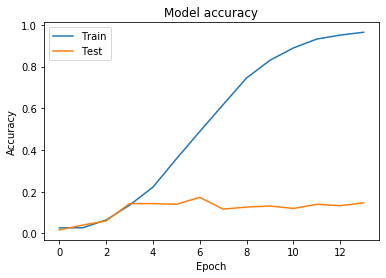

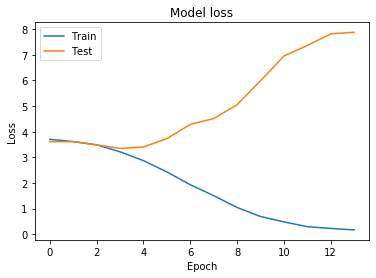

In [13]:
early_stop = EarlyStopping(patience=10)

history_1 = model.fit_generator(
            generator=train_generator,
            steps_per_epoch=train_generator.n // batch_size,
            validation_data=val_generator,
            validation_steps=val_generator.n // batch_size,
            epochs=100,
            verbose=2,
            callbacks=[early_stop])

plot_history([history_1])

In [27]:
model = conv_model(size=3, lr=0.001, use_dropout=False, use_batchnorm=True, use_globalpool=True)
model.summary()

plot_model(model, to_file='size=3,lr=0.001,use_dropout=False,use_batchnorm=True,use_globalpool=True.png',
           show_shapes=False, show_layer_names=False)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_37 (Conv2D)           (None, 112, 112, 64)      9472      
_________________________________________________________________
batch_normalization_6 (Batch (None, 112, 112, 64)      256       
_________________________________________________________________
activation_37 (Activation)   (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 56, 56, 128)       73856     
_________________________________________________________________
batch_normalization_7 (Batch (None, 56, 56, 128)       512       
_________________________________________________________________
activation_38 (Activation)   (None, 56, 56, 128)       0         
__________

Epoch 1/100
 - 20s - loss: 3.5308 - categorical_accuracy: 0.0655 - val_loss: 5.5879 - val_categorical_accuracy: 0.0299
Epoch 2/100
 - 21s - loss: 3.3241 - categorical_accuracy: 0.1014 - val_loss: 3.9566 - val_categorical_accuracy: 0.0432
Epoch 3/100
 - 17s - loss: 3.1250 - categorical_accuracy: 0.1412 - val_loss: 6.0746 - val_categorical_accuracy: 0.0299
Epoch 4/100
 - 20s - loss: 2.9445 - categorical_accuracy: 0.1846 - val_loss: 4.4916 - val_categorical_accuracy: 0.0764
Epoch 5/100
 - 20s - loss: 2.8310 - categorical_accuracy: 0.2068 - val_loss: 4.0562 - val_categorical_accuracy: 0.0844
Epoch 6/100
 - 18s - loss: 2.6966 - categorical_accuracy: 0.2410 - val_loss: 3.9271 - val_categorical_accuracy: 0.0731
Epoch 7/100
 - 18s - loss: 2.5790 - categorical_accuracy: 0.2673 - val_loss: 4.2192 - val_categorical_accuracy: 0.0997
Epoch 8/100
 - 17s - loss: 2.4425 - categorical_accuracy: 0.3024 - val_loss: 3.4851 - val_categorical_accuracy: 0.1462
Epoch 9/100
 - 17s - loss: 2.3833 - categorical_

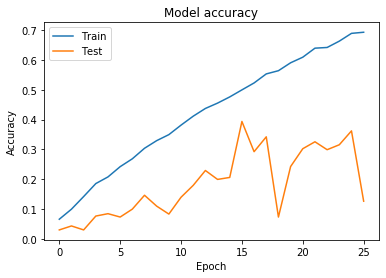

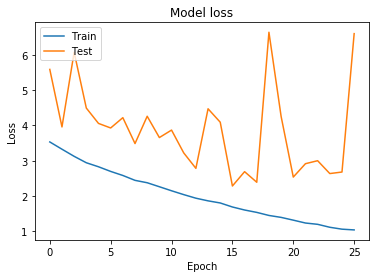

In [26]:
early_stop = EarlyStopping(patience=10)

history_2 = model.fit_generator(
            generator=train_generator,
            steps_per_epoch=train_generator.n // batch_size,
            validation_data=val_generator,
            validation_steps=val_generator.n // batch_size,
            epochs=100,
            verbose=2,
            callbacks=[early_stop])

plot_history([history_2])

In [28]:
model = conv_model(size=3, lr=0.001, use_dropout=True, use_batchnorm=True, use_globalpool=True)
model.summary()

plot_model(model, to_file='size=3,lr=0,001,use_dropout=True,use_batchnorm=True,use_globalpool=True',
           show_shapes=False, show_layer_names=False)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_42 (Conv2D)           (None, 112, 112, 64)      9472      
_________________________________________________________________
batch_normalization_11 (Batc (None, 112, 112, 64)      256       
_________________________________________________________________
activation_42 (Activation)   (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 56, 56, 128)       73856     
_________________________________________________________________
batch_normalization_12 (Batc (None, 56, 56, 128)       512       
_________________________________________________________________
activation_43 (Activation)   (None, 56, 56, 128)       0         
__________

Epoch 1/100
 - 22s - loss: 3.9632 - categorical_accuracy: 0.0359 - val_loss: 3.9728 - val_categorical_accuracy: 0.0266
Epoch 2/100
 - 17s - loss: 3.7023 - categorical_accuracy: 0.0431 - val_loss: 3.9719 - val_categorical_accuracy: 0.0365
Epoch 3/100
 - 17s - loss: 3.5835 - categorical_accuracy: 0.0491 - val_loss: 3.6195 - val_categorical_accuracy: 0.0399
Epoch 4/100
 - 17s - loss: 3.5004 - categorical_accuracy: 0.0648 - val_loss: 4.2606 - val_categorical_accuracy: 0.0266
Epoch 5/100
 - 18s - loss: 3.4227 - categorical_accuracy: 0.0810 - val_loss: 3.5879 - val_categorical_accuracy: 0.0500
Epoch 6/100
 - 18s - loss: 3.3803 - categorical_accuracy: 0.0846 - val_loss: 3.6173 - val_categorical_accuracy: 0.0432
Epoch 7/100
 - 17s - loss: 3.2826 - categorical_accuracy: 0.1059 - val_loss: 3.6531 - val_categorical_accuracy: 0.0432
Epoch 8/100
 - 18s - loss: 3.2255 - categorical_accuracy: 0.1154 - val_loss: 4.3772 - val_categorical_accuracy: 0.0365
Epoch 9/100
 - 18s - loss: 3.1580 - categorical_

Epoch 70/100
 - 17s - loss: 0.5721 - categorical_accuracy: 0.8254 - val_loss: 1.2243 - val_categorical_accuracy: 0.6379
Epoch 71/100
 - 17s - loss: 0.6049 - categorical_accuracy: 0.8176 - val_loss: 1.1690 - val_categorical_accuracy: 0.6687
Epoch 72/100
 - 17s - loss: 0.6492 - categorical_accuracy: 0.7967 - val_loss: 1.4707 - val_categorical_accuracy: 0.6047
Epoch 73/100
 - 17s - loss: 0.5617 - categorical_accuracy: 0.8282 - val_loss: 1.1511 - val_categorical_accuracy: 0.6611
Epoch 74/100
 - 17s - loss: 0.6224 - categorical_accuracy: 0.8166 - val_loss: 1.5509 - val_categorical_accuracy: 0.5349
Epoch 75/100
 - 17s - loss: 0.5588 - categorical_accuracy: 0.8319 - val_loss: 1.0443 - val_categorical_accuracy: 0.7010
Epoch 76/100
 - 18s - loss: 0.5480 - categorical_accuracy: 0.8285 - val_loss: 1.2120 - val_categorical_accuracy: 0.6279
Epoch 77/100
 - 18s - loss: 0.5197 - categorical_accuracy: 0.8403 - val_loss: 1.2656 - val_categorical_accuracy: 0.6545
Epoch 78/100
 - 17s - loss: 0.5349 - cat

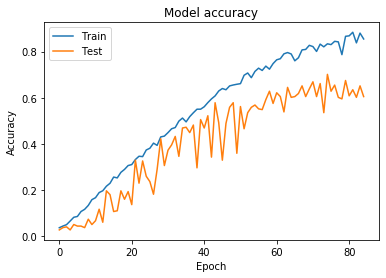

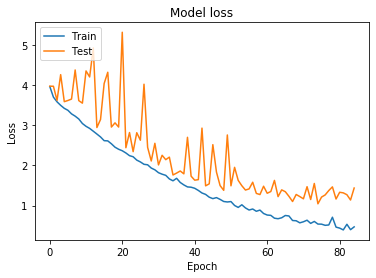

In [29]:
early_stop = EarlyStopping(patience=10)

history_2 = model.fit_generator(
            generator=train_generator,
            steps_per_epoch=train_generator.n // batch_size,
            validation_data=val_generator,
            validation_steps=val_generator.n // batch_size,
            epochs=100,
            verbose=2,
            callbacks=[early_stop])

plot_history([history_2])

In [30]:
model.save('best_model-augdata.h5')

In [32]:
best_model = load_model('best_model-augdata.h5')
best_model.optimizer = Adam(lr=0.00001)

Epoch 1/10
 - 21s - loss: 0.4056 - categorical_accuracy: 0.8850 - val_loss: 1.4900 - val_categorical_accuracy: 0.5947
Epoch 2/10
 - 17s - loss: 0.4091 - categorical_accuracy: 0.8818 - val_loss: 1.1230 - val_categorical_accuracy: 0.6719
Epoch 3/10
 - 17s - loss: 0.3965 - categorical_accuracy: 0.8795 - val_loss: 1.5809 - val_categorical_accuracy: 0.5814
Epoch 4/10
 - 17s - loss: 0.3320 - categorical_accuracy: 0.9047 - val_loss: 1.4911 - val_categorical_accuracy: 0.5681
Epoch 5/10
 - 17s - loss: 0.4405 - categorical_accuracy: 0.8718 - val_loss: 1.3411 - val_categorical_accuracy: 0.6445
Epoch 6/10
 - 17s - loss: 0.3285 - categorical_accuracy: 0.9022 - val_loss: 1.4993 - val_categorical_accuracy: 0.6047
Epoch 7/10
 - 17s - loss: 0.3637 - categorical_accuracy: 0.8881 - val_loss: 1.3553 - val_categorical_accuracy: 0.6379
Epoch 8/10
 - 17s - loss: 0.3158 - categorical_accuracy: 0.9089 - val_loss: 1.1763 - val_categorical_accuracy: 0.6179
Epoch 9/10
 - 17s - loss: 0.2855 - categorical_accuracy:

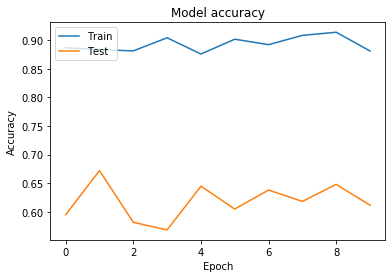

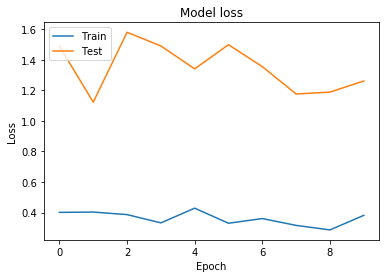

In [33]:
early_stop = EarlyStopping(patience=10)

history_ = best_model.fit_generator(
            generator=train_generator,
            steps_per_epoch=train_generator.n // batch_size,
            validation_data=val_generator,
            validation_steps=val_generator.n // batch_size,
            epochs=10,
            verbose=2,
            callbacks=[early_stop])

plot_history([history_])

In [34]:
test_data = pandas.read_csv('../test_pets.csv', usecols=['Category', 'Path'])
test_datagen = ImageDataGenerator(rescale=1. / 255)
test_generator = test_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='.',
        x_col='Path',
        y_col='Category',
        class_mode='categorical',
        target_size=input_shape,
        interpolation='bicubic',
        batch_size=batch_size)

Found 333 validated image filenames belonging to 37 classes.


In [44]:
history = best_model.evaluate_generator(
        test_generator,
        steps=test_generator.n // batch_size,
        verbose=1)

print(f'Test loss: {history[0]}, Test accuracy: {history[1]}')

10/10 [==============================] - 1s 68ms/step
Test loss: 1.2920658350782932, Test accuracy: 0.6046511628897087


Original: american_bulldog
american_pit_bull_terrier 0.33563614
german_shorthaired 0.27838314
staffordshire_bull_terrier 0.14041328


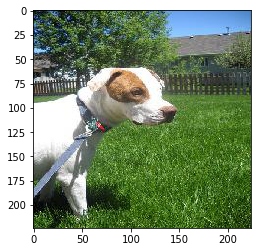

In [49]:
sample = test_generator.next()
image_array = sample[0]
categories_dict = {value: key for key, value in test_generator.class_indices.items()}
category = categories_dict[np.argmax(sample[1][0])]

predictions = best_model.predict(image_array)[0]

best_args = np.argsort(predictions)[::-1][:3]

print(f'Original: {category}')
for i in best_args:
    print(categories_dict[i], predictions[i])

plt.imshow(image_array[0])